# **0. Loading libraries and data**

### **0.1 Import necessary libraries**

In [1]:
import re as re
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import string
import nltk
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")
import time




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **0.2 Read data from CSV file**

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Reviews.csv")

Mounted at /content/drive


### Data set uploaded to google drive
Link: https://drive.google.com/file/d/1RbK8ksKgzloL6utnDkGkDcl09ex2FxGH/view?usp=sharing

### **0.3 Data format**

In [3]:
print(data.iloc[0])

Id                                                                        1
ProductId                                                        B001E4KFG0
UserId                                                       A3SGXH7AUHU8GW
ProfileName                                                      delmartian
HelpfulnessNumerator                                                      1
HelpfulnessDenominator                                                    1
Score                                                                     5
Time                                                             1303862400
Summary                                               Good Quality Dog Food
Text                      I have bought several of the Vitality canned d...
Name: 0, dtype: object


### **0.4 Data set statistics**

In [4]:
print("Number of reviews :", data.shape[0])
print("Number of products :", data.ProductId.nunique())
print("Number of users :", data.UserId.nunique())

Number of reviews : 568454
Number of products : 74258
Number of users : 256059


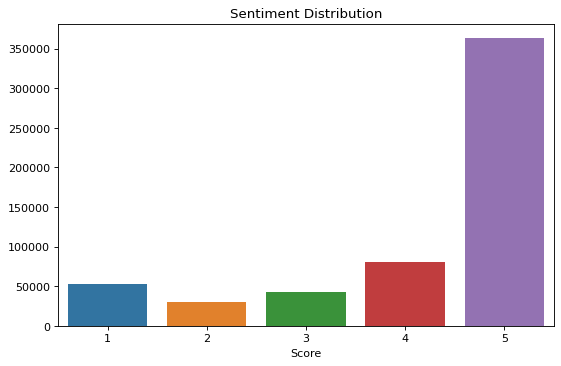

In [5]:
dist = data.groupby(["Score"]).size()
fig, ax = plt.subplots(figsize=(8,5), dpi=80)
ax.set_title('Sentiment Distribution')
sns.barplot(dist.keys(), dist.values);

# **1. Pre-processing**

### **1.1 Adding sentiment column**

In [6]:
data['Class'] = np.where(data['Score'] >= 3, 'Positive', 'Negative')
def partition(x):
    if x < 3:
        return 0
    return 1

score_upd = data['Score']
t = score_upd.map(partition)
data['Sentiment']=t
data.drop(data[data.Score == 3].index, inplace=True)
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Class,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0


### **1.2 Duplicates**

In [7]:
data[['UserId', 'Time', 'Summary', 'Text']].loc[data['UserId'] == 'AR5J8UI46CURR']

,UserId,Time,Summary,Text
73790,AR5J8UI46CURR,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
78444,AR5J8UI46CURR,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138276,AR5J8UI46CURR,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138316,AR5J8UI46CURR,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155048,AR5J8UI46CURR,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
filtered_data = data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
filtered_data[['UserId', 'Time', 'Summary', 'Text']].loc[filtered_data['UserId'] == 'AR5J8UI46CURR']


,UserId,Time,Summary,Text
73790,AR5J8UI46CURR,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [9]:
print("Percentage of data fltered out: ", 100- (filtered_data['Id'].size * 1.0) / (data['Id'].size  *1.0) * 100)

Percentage of data fltered out:  30.741098563370315


### **1.3 Case convertion**

In [10]:
print("Before converting to lower case: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'AR5J8UI46CURR'].values)

print()
filtered_data['Text'] = filtered_data['Text'].str.lower()
print("After converting to lower case: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'AR5J8UI46CURR'].values)

Before converting to lower case: 
['DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ARE LESS SWEET ( LESS SUGAR AND CARBOHYDRATES) BUT VERY DELECTABLE.']

After converting to lower case: 
['delicious wafers. i find that european wafers are less sweet ( less sugar and carbohydrates) but very delectable.']


### **1.4 HTML tags**

In [11]:
print("Before removing HTML tags: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'A3FONPR03H3PJS'].values) 
print()
pd.options.mode.chained_assignment = None
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6})')

def remove_tags(string):
    result = re.sub(CLEANR,'',string)
    return result

filtered_data['Text'] = filtered_data['Text'].apply(lambda sentence : remove_tags(sentence))
print("After removing HTML tags: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'A3FONPR03H3PJS'].values)

Before removing HTML tags: 
['product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/b001gvisjm">twizzlers, strawberry, 16-ounce bags (pack of 6)</a>'
 'best price for wasa crispbread, multi grain, 9.7-ounce boxes (pack of 12)is to order through amazon.com "subscribe & save items"'
 'product received is as advertised.  <a href="http://www.amazon.com/gp/product/b002edemly">red vines red original licorice twists, 64-ounce tub</a>']

After removing HTML tags: 
['product received is as advertised.twizzlers, strawberry, 16-ounce bags (pack of 6)'
 'best price for wasa crispbread, multi grain, 9.7-ounce boxes (pack of 12)is to order through amazon.com "subscribe & save items"'
 'product received is as advertised.  red vines red original licorice twists, 64-ounce tub']


### **1.5 Contractions**

In [12]:
contractions_dict = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}


print("Before expanding: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'A3HDKO7OW0QNK4'].values)
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text, contractions_dict = contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
filtered_data['Text'] = filtered_data['Text'].apply(lambda x:expand_contractions(x))

print()
print("After expanding: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'A3HDKO7OW0QNK4'].values)

# removing punctuations
filtered_data['Text'] = filtered_data['Text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

Before expanding: 
["i don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  we picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  when we realized that we simply couldn't find it anywhere in our city we were bummed.now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.if you love hot sauce..i mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of tequila picante gourmet de inclan.  just realize that once you taste it, you will never want to use any other sauce.thank you for the personal, incredible service!"
 "just as with the original tequila picante gourmet de inclan hot sauce, this salsa has a unique, addictive flavour.  we've been a salsa family for two decades but have never tasted any salsa at home which has the rounded, authentic f

### **1.6 Stop words**

In [13]:
print("Before removing stop words: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'AR5J8UI46CURR'].values)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

filtered_data['Text'] = filtered_data['Text'].apply(lambda x: remove_stopwords(x))
print()
print("After removing stop words: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'AR5J8UI46CURR'].values)

Before removing stop words: 
['delicious wafers i find that european wafers are less sweet  less sugar and carbohydrates but very delectable']

After removing stop words: 
['delicious wafers find european wafers less sweet less sugar carbohydrates delectable']


### **1.7 Non alphabetic characters**

In [14]:
def remove_non_alphabetic(text):
    return " ".join([word for word in str(text).split() if word.isalpha()])

filtered_data['Text'] = filtered_data['Text'].apply(lambda x: remove_non_alphabetic(x))

### **1.8 Lemmatization**

In [15]:
print("Before lemmatization: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'A21BT40VZCCYT4'].values)

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
filtered_data['Text'] = filtered_data['Text'].apply(lambda x: lemmatize_words(x))
print()
print("After lemmatization: ")
print(filtered_data['Text'].loc[filtered_data['UserId'] == 'A21BT40VZCCYT4'].values)

Before lemmatization: 
['healthy dog food good digestion also good small puppies dog eats required amount every feeding'
 'dog come outside training look cupboard waiting treat use clicker training method comes knows something special']

After lemmatization: 
['healthy dog food good digestion also good small puppy dog eats required amount every feeding'
 'dog come outside training look cupboard waiting treat use clicker training method come know something special']


### **1.9 Test - Train split and Vectorization**

In [16]:
x = filtered_data['Text']
y = filtered_data['Class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train_lstm = x_train
x_test_lstm = x_test
count_vector = CountVectorizer(lowercase = "true")
x_train = count_vector.fit_transform(x_train)
x_test = count_vector.transform(x_test)

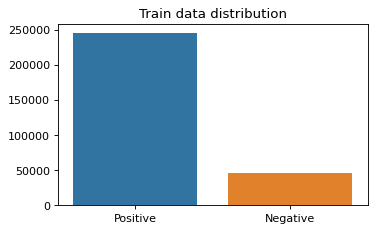

In [17]:
dist = y_train.value_counts()
fig, ax = plt.subplots(figsize=(5,3), dpi = 80)
ax.set_title('Train data distribution')
sns.barplot(dist.keys(), dist.values);

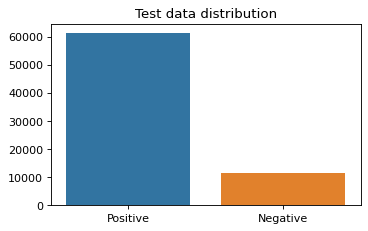

In [18]:
dist = y_test.value_counts()
fig, ax = plt.subplots(figsize=(5,3), dpi=80)
ax.set_title('Test data distribution')
sns.barplot(dist.keys(), dist.values);

accuracy_dict = {}
f1_dict = {}


# **2. Models**

### **2.1 Naive Bayes**

In [19]:
#10 fold cross validation for naive bayes
def find_alpha(X_train, y_train):
    alpha_values = np.arange(1, 5, 0.5)
    cv_scores = []
    for alpha in alpha_values:
        mnb = MultinomialNB(alpha = alpha)
        scores = cross_val_score(mnb, X_train, y_train, cv = 10, scoring = 'accuracy')
        cv_scores.append(scores.mean())
    MSE = [1 - x for x in cv_scores]
    optimal_alpha = alpha_values[MSE.index(min(MSE))]
    plt.plot(alpha_values, MSE, marker = '*') 
    plt.title("Misclassification Error vs alpha")
    plt.xlabel('value of alpha')
    plt.ylabel('Misclassification Error')
    plt.show()
    return optimal_alpha

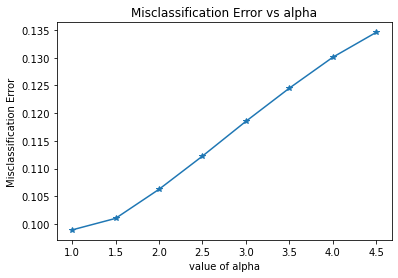

Optimal value of alpha is:  1.0
---Runtime: 276.04744267463684 seconds ---


In [20]:
#Naive bayes
start_time = time.time()
alpha_optimal = find_alpha(x_train, y_train)
print("Optimal value of alpha is: ", alpha_optimal)
naive_bayes =  MultinomialNB(alpha = alpha_optimal)
naive_bayes.fit(x_train, y_train)
y_pred_naive_bayes = naive_bayes.predict(x_test)
print("---Runtime: %s seconds ---" % (time.time() - start_time))

In [21]:
def print_metrics(y_test, y_pred, name):
  acc = accuracy_score(y_test, y_pred)
  accuracy_dict[name] = round(acc*100, 2)
  print("Accuracy:", acc)
  print("Precision for positive:",precision_score(y_test, y_pred, pos_label = "Positive"))
  print("Precision for negative:",precision_score(y_test, y_pred, pos_label = "Negative"))
  print("Recall for positive:",recall_score(y_test, y_pred, pos_label = "Positive"))
  print("Recall for negative:",recall_score(y_test, y_pred, pos_label = "Negative"))
  f1score = f1_score(y_test, y_pred, average='weighted')
  f1_dict[name] = round(f1score*100, 2)
  print("F1 Score::", f1score)

In [22]:
print_metrics(y_test, y_pred_naive_bayes, "Naive Bayes")

Accuracy: 0.9083407702340908
Precision for positive: 0.9238455222840147
Precision for negative: 0.7874909442163729
Recall for positive: 0.9713341042721957
Recall for negative: 0.5702045812204931
F1 Score:: 0.90215455107965


In [23]:
def print_confusion_matrix(y_test, y_predicted):
  cnf_matrix = confusion_matrix(y_test, y_predicted)
  class_names=['Negative','Positive']
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("bottom")
  plt.tight_layout()
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

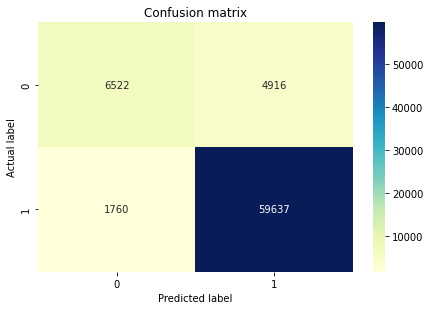

In [24]:
print_confusion_matrix(y_test, y_pred_naive_bayes)

### **2.2 Logistic Regression**

In [25]:
#Logistic regression
start_time = time.time()
lr = LogisticRegression(solver='lbfgs',max_iter=1000)
lr.fit(x_train, y_train)
y_pred_log_regression = lr.predict(x_test)
print("---Runtime: %s seconds ---" % (time.time() - start_time))

---Runtime: 120.76229429244995 seconds ---


In [26]:
print_metrics(y_test, y_pred_log_regression, "Logistic Regression")

Accuracy: 0.9235395071051006
Precision for positive: 0.9410491388844999
Precision for negative: 0.8074384494499738
Recall for positive: 0.9700636838933498
Recall for negative: 0.6738066095471236
F1 Score:: 0.920670943637487


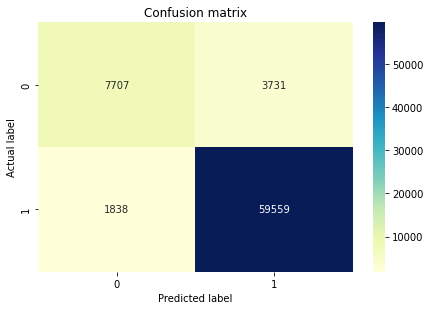

In [27]:
print_confusion_matrix(y_test, y_pred_log_regression)

### **2.3 XgBoost**

In [28]:
#training the model
start_time = time.time()
xgb = XGBClassifier(random_state = 22,learning_rate = 0.7)
xgb.fit(x_train, y_train)

#predicting the labels for test data
y_pred_xgb = xgb.predict(x_test)
print("---Runtime: %s seconds ---" % (time.time() - start_time))

---Runtime: 90.08836364746094 seconds ---


In [29]:
print_metrics(y_test, y_pred_xgb, "XgBoost")

Accuracy: 0.905402622365621
Precision for positive: 0.9157475630405931
Precision for negative: 0.8122768470200494
Recall for positive: 0.9777350684886884
Recall for negative: 0.5171358629130967
F1 Score:: 0.8964503404637667


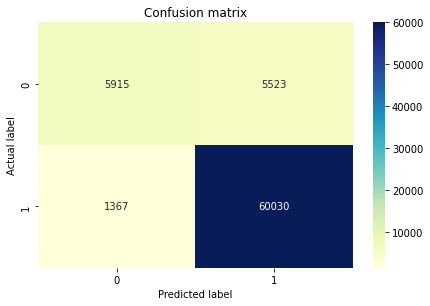

In [30]:
print_confusion_matrix(y_test, y_pred_xgb)

### **2.4 LSTM**

In [31]:
train_db, test_db = train_test_split(filtered_data, test_size = 0.2, random_state = 42)
tokenizer = Tokenizer(num_words=6500)
tokenizer.fit_on_texts(train_db['Text'])
sequences_train = tokenizer.texts_to_sequences(train_db['Text'])

X_train = pad_sequences(sequences_train, maxlen=140)
Y_train = train_db['Sentiment']

In [32]:
model = Sequential()
model.add(Embedding(6501, 32, input_length=140))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 140, 32)           208032    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 261,333
Trainable params: 261,333
Non-trainable params: 0
_________________________________________________________________


In [33]:
start_time = time.time()
model.fit(X_train,Y_train, epochs=3, batch_size=64, validation_split=0.2)
print("---Runtime: %s seconds ---" % (time.time() - start_time))

Epoch 1/3
3642/3642 [==============================] - 722s 197ms/step - loss: 0.2123 - accuracy: 0.9164 - val_loss: 0.1932 - val_accuracy: 0.9244
Epoch 2/3
3642/3642 [==============================] - 700s 192ms/step - loss: 0.1746 - accuracy: 0.9313 - val_loss: 0.1851 - val_accuracy: 0.9277
Epoch 3/3
3642/3642 [==============================] - 693s 190ms/step - loss: 0.1570 - accuracy: 0.9385 - val_loss: 0.1803 - val_accuracy: 0.9282
---Runtime: 2124.5963747501373 seconds ---


In [34]:
list_tokenized_test = tokenizer.texts_to_sequences(test_db['Text'])
X_test = pad_sequences(list_tokenized_test, maxlen=140)
y_test = test_db['Sentiment']
prediction = model.predict(X_test)
y_pred_lstm = (prediction > 0.5)

In [35]:
acc = accuracy_score(y_test, y_pred_lstm)
print("Accuracy:",acc)
accuracy_dict["LSTM"] = round(acc*100, 2)
print("Precision for positive:",precision_score(y_test, y_pred_lstm, pos_label = 1))
print("Precision for negative:",precision_score(y_test, y_pred_lstm, pos_label = 0))
print("Recall for positive:",recall_score(y_test, y_pred_lstm, pos_label = 1))
print("Recall for negative:",recall_score(y_test, y_pred_lstm, pos_label = 0))
f1score = f1_score(y_test, y_pred_lstm, average='weighted')
f1_dict["LSTM"] = round(f1score*100, 2)
print("F1 Score::", f1score)

Accuracy: 0.9289215349763164
Precision for positive: 0.9494867120790559
Precision for negative: 0.8040205885209284
Recall for positive: 0.9671319445575517
Recall for negative: 0.7238153523343241
F1 Score:: 0.9273830581132583


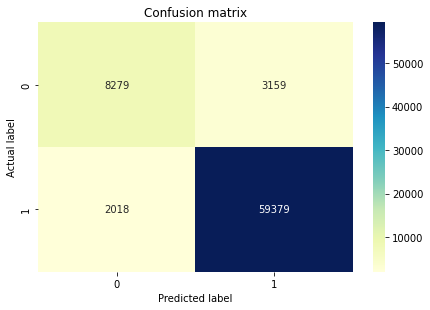

In [36]:
print_confusion_matrix(y_test, y_pred_lstm)

In [37]:
def plot_metrcis(acc, metric):
  models = list(acc.keys())
  accuracy = list(acc.values())
    
  fig = plt.figure(figsize = (8, 5))
  
  # creating the bar plot
  plt.bar(models, accuracy[0:100], color=(0.2, 0.4, 0.6, 0.6), width = 0.4)
  
  plt.xlabel("Models")
  plt.ylabel(metric)
  plt.title(metric + " of different models")
  for i, v in enumerate(accuracy):
      plt.text(i - 0.10, v + 0.50, str(v))

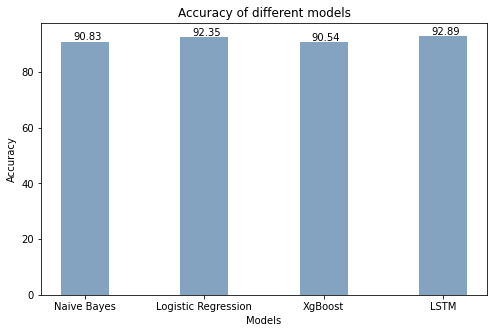

In [38]:
plot_metrcis(accuracy_dict, "Accuracy")